In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
img_width, img_height = 150, 150

In [3]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 1075
nb_validation_samples = 100
epochs = 10
batch_size = 16

In [4]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('data/train/Articuno/0aac0ced-4450-4065-ac58-79af0749a627.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview', save_prefix='articuno', 
                         save_format='jpeg'):
    i += 1
    if i > 20:
        break

## First model: CNN from scratch (baseline)

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [7]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'data/validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1075 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [44]:
epochs = 10
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
24/67 [=========>....................] - ETA: 57s - loss: 0.4847 - acc: 0.8247

c:\users\robertalonso\anaconda2\envs\tensorflow1\lib\site-packages\PIL\Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


67/67 [==============================] - 117s - loss: 0.5672 - acc: 0.8066 - val_loss: 0.5732 - val_acc: 0.8452
Epoch 2/10
67/67 [==============================] - 107s - loss: 0.6258 - acc: 0.7975 - val_loss: 0.5999 - val_acc: 0.8214
Epoch 3/10
67/67 [==============================] - 102s - loss: 0.5347 - acc: 0.8125 - val_loss: 0.6314 - val_acc: 0.8452
Epoch 4/10
67/67 [==============================] - 102s - loss: 0.5731 - acc: 0.8162 - val_loss: 0.4733 - val_acc: 0.8571
Epoch 5/10
67/67 [==============================] - 97s - loss: 0.5621 - acc: 0.8010 - val_loss: 0.4492 - val_acc: 0.8690
Epoch 6/10
67/67 [==============================] - 88s - loss: 0.4992 - acc: 0.8346 - val_loss: 0.7516 - val_acc: 0.8214
Epoch 7/10
67/67 [==============================] - 96s - loss: 0.5367 - acc: 0.8358 - val_loss: 0.5302 - val_acc: 0.8452
Epoch 8/10
67/67 [==============================] - 94s - loss: 0.4581 - acc: 0.8489 - val_loss: 0.4535 - val_acc: 0.8571
Epoch 9/10
67/67 [=============

In [45]:
model.save_weights('pokedex_3.h5')

In [12]:
model.load_weights('pokedex_3.h5')

In [13]:
classes = {v: k for k, v in train_generator.class_indices.items()}
classes

{0: 'Abra',
 1: 'Aerodactyl',
 2: 'Alakazam',
 3: 'Arbok',
 4: 'Arcanine',
 5: 'Articuno',
 6: 'Beedrill',
 7: 'Bellsprout',
 8: 'Ivysaur',
 9: 'Venusaur'}

'Bellsprout'

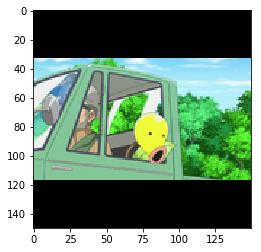

In [23]:
%matplotlib inline
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

img = load_img('data/test/bellsprout4.png')
img.thumbnail((img_width, img_height), Image.ANTIALIAS)
new_img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
new_img.paste(img, ((img_width - img.size[0]) // 2, (img_height - img.size[1]) // 2))
imshow(new_img)

x = img_to_array(new_img)
x = x.reshape((1,) + x.shape)
classes[np.argmax(model.predict(x))]

In [18]:
model.save_weights('pokedex_model.hdf5')
with open('pokedex_model.json', 'w') as f:
    f.write(model.to_json())

## Second Model: Use features of pretrained VGG16 net

In [23]:
from keras import applications
top_model_weights_path = 'bottleneck_fc_model.h5'

In [123]:
pre_model = applications.VGG16(include_top=False, weights='imagenet')
pred = model.predict(pre_model.predict(x))
print(pred)
print("cat" if pred[0][0]>0.5 else "dog")

[[ 1.]]
cat


In [6]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)    
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)

In [7]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
    
    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [ ]:
save_bottleneck_features()

In [ ]:
train_top_model()

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)
model = applications.VGG16(include_top=False, weights='imagenet')

In [11]:
generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)  

Found 2000 images belonging to 2 classes.


In [15]:
bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size, verbose=1)

125/125 [==============================] - 900s   


In [25]:
np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

In [26]:
generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 800 images belonging to 2 classes.


In [27]:
bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size, verbose=1)

50/50 [==============================] - 379s   


In [28]:
np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [79]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array(
    [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array(
    [1] * (nb_validation_samples // 2) + [0] * (nb_validation_samples // 2))

In [82]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
epochs = 50
model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 5s - loss: 0.9567 - acc: 0.5995 - val_loss: 0.4660 - val_acc: 0.8113
Epoch 2/50
2000/2000 [==============================] - 5s - loss: 0.6223 - acc: 0.6835 - val_loss: 0.4617 - val_acc: 0.7850
Epoch 3/50
2000/2000 [==============================] - 4s - loss: 0.5711 - acc: 0.7155 - val_loss: 0.4066 - val_acc: 0.8163
Epoch 4/50
2000/2000 [==============================] - 5s - loss: 0.5388 - acc: 0.7435 - val_loss: 0.3977 - val_acc: 0.8200
Epoch 5/50
2000/2000 [==============================] - 6s - loss: 0.5026 - acc: 0.7650 - val_loss: 0.4135 - val_acc: 0.8113
Epoch 6/50
2000/2000 [==============================] - 4s - loss: 0.4669 - acc: 0.7895 - val_loss: 0.3999 - val_acc: 0.8137
Epoch 7/50
2000/2000 [==============================] - 5s - loss: 0.4414 - acc: 0.8045 - val_loss: 0.4021 - val_acc: 0.8063
Epoch 8/50
2000/2000 [==============================] - 7s - loss: 0.4204 - ac

## Fine tune VGG net

In [140]:
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
img_width, img_height = 150, 150

In [145]:
model = applications.VGG16(weights='imagenet', include_top=False,
                               input_shape=(img_width, img_height, 3))

In [146]:
vgg_model = Sequential()
for l in model.layers:
    vgg_model.add(l)

In [147]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [148]:
top_model.load_weights(top_model_weights_path)

In [149]:
vgg_model.add(top_model)

In [150]:
for layer in vgg_model.layers[:25]:
    layer.trainable = False

In [152]:
from keras import optimizers
vgg_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [153]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [154]:
epochs = 10
vgg_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

c:\users\robertalonso\anaconda2\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_steps=800, validation_data=<keras.pre..., epochs=10, steps_per_epoch=125)`
  import sys


Epoch 1/10
124/125 [============================>.] - ETA: 7s - loss: 9.5088 - acc: 0.1744 

KeyboardInterrupt: 